In [1]:
import tensorflow as tf
import numpy as np
import os
import PIL
import PIL.Image
#import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [2]:
root_dir = os.path.join(os.getcwd(),'dataset')

num_categories = 21
num_data_arr = []
label_data_arr = []
file_arr = []

for img_data_root, img_data_dirs, img_data_files in os.walk(os.path.join(root_dir, 'images')):
    if img_data_root == os.path.join(root_dir, 'images'):
        label_data_arr = img_data_dirs
    img_data_files = [x for x in img_data_files if x.lower().endswith('.jpg')]
    num_data_arr.append(len(img_data_files))
    img_data_files = list(map(lambda x:os.path.join(img_data_root,x),img_data_files))
    file_arr.append(img_data_files)
    
num_data_arr.pop(0)
file_arr.pop(0)

label_num_dict = dict(zip(label_data_arr,num_data_arr))
label_file_dict = dict(zip(label_data_arr,file_arr))

num_data_total = sum(num_data_arr)

print("Root directory: " + root_dir)
print("Number of categories: " + str(num_categories))
print("Total number of data: " + str(num_data_total))

Root directory: C:\Users\Wahyu effendi\Downloads\capstone-project\dataset
Number of categories: 21
Total number of data: 4200


In [3]:
data_dir = os.path.join(root_dir,'images')

batch_size = 32
img_height = 224
img_width = 224

#create dataset from images directory
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4200 files belonging to 21 classes.
Using 3360 files for training.
Found 4200 files belonging to 21 classes.
Using 840 files for validation.


In [4]:
class_names = train_ds.class_names
print(class_names)

['cake', 'chicken_rice', 'chicken_wings', 'donuts', 'egg', 'fish', 'french_fries', 'fried_chicken', 'fried_rice', 'hamburger', 'hot_pot', 'ice_cream', 'noodle', 'omelette', 'pizza', 'sashimi', 'spaghetti', 'steak', 'sushi', 'toast', 'vegetables']


In [5]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [6]:
for image_batch, labels_batch in val_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [7]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 22
Number of test batches: 5


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

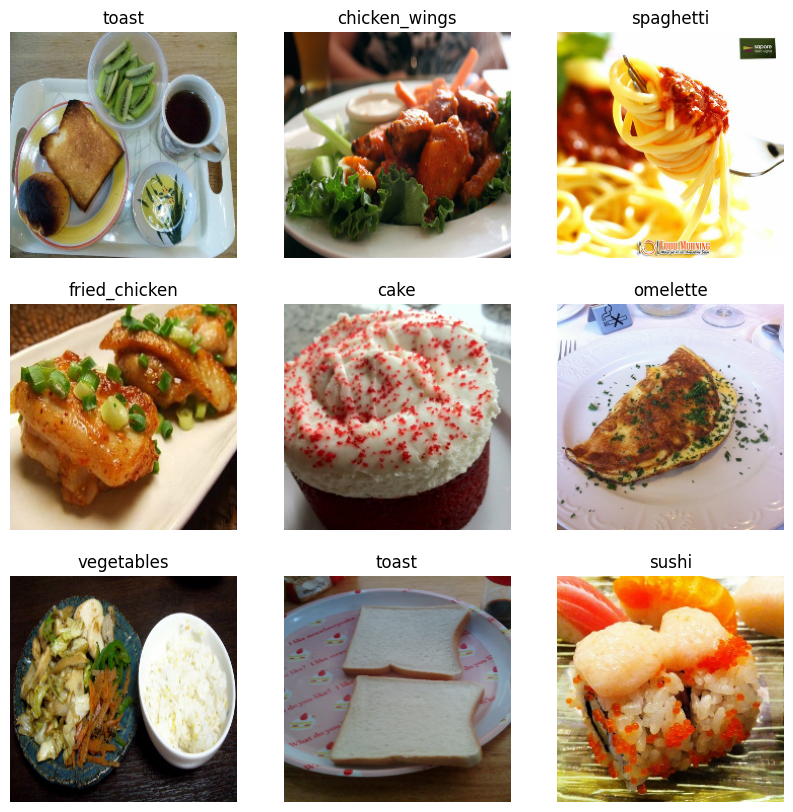

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [28]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
])

In [11]:
pre_trained = tf.keras.applications.MobileNetV3Large(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet'
)

pre_trained.trainable = False

model = tf.keras.Sequential([
    #data_augmentation,
    pre_trained,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(21, activation='softmax'),
])

model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

#model.summary()

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 960)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               123008    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 21)                2709      
                                                                 
Total params: 3,122,069
Trainable params: 125,717
Non-tr

In [13]:
ACCURACY_THRESHOLD = 0.75

class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('accuracy') > ACCURACY_THRESHOLD):   
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))   
            self.model.stop_training = True

In [14]:
checkpoint_filepath = 'tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='accuracy',
    mode='max',
    save_best_only=True)

In [15]:
#MobileNetV3
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='loss',
            patience=3,
            mode='min',
            restore_best_weights=True
        ),
        model_checkpoint_callback
        #myCallback()
    ]
)

Epoch 1/20
105/105 [==============================] - 91s 818ms/step - loss: 1.6907 - accuracy: 0.5092 - val_loss: 0.9687 - val_accuracy: 0.7250
Epoch 2/20
105/105 [==============================] - 74s 702ms/step - loss: 0.8544 - accuracy: 0.7432 - val_loss: 0.7912 - val_accuracy: 0.7794
Epoch 3/20
105/105 [==============================] - 71s 676ms/step - loss: 0.6202 - accuracy: 0.8146 - val_loss: 0.7385 - val_accuracy: 0.7809
Epoch 4/20
105/105 [==============================] - 72s 684ms/step - loss: 0.4610 - accuracy: 0.8646 - val_loss: 0.7139 - val_accuracy: 0.7838
Epoch 5/20
105/105 [==============================] - 72s 687ms/step - loss: 0.3901 - accuracy: 0.8777 - val_loss: 0.6650 - val_accuracy: 0.7971
Epoch 6/20
105/105 [==============================] - 75s 714ms/step - loss: 0.3002 - accuracy: 0.9161 - val_loss: 0.6431 - val_accuracy: 0.8176
Epoch 7/20
105/105 [==============================] - 101s 957ms/step - loss: 0.2465 - accuracy: 0.9310 - val_loss: 0.6857 - val_a

KeyboardInterrupt: 

In [16]:
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc))

plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.legend(['train_acc','val_acc'])
plt.figure()

plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )

NameError: name 'history' is not defined

# Test Model

In [57]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

5/5 [==============================] - 2s 387ms/step - loss: 2.9601 - accuracy: 0.0875
Test accuracy : 0.08749999850988388


# Save Model Weights

In [40]:
# Save the weights
model.save_weights('./checkpoints/my_checkpoint_1')

In [19]:
# Restore the weights
model.load_weights('./checkpoints/my_checkpoint_1')

# Evaluate the model
loss, acc = model.evaluate(test_ds)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

5/5 [==============================] - 5s 820ms/step - loss: 0.6099 - accuracy: 0.8313
Restored model, accuracy: 83.13%


In [18]:
# Restore the weights
model.load_weights('tmp/checkpoint')

# Evaluate the model
loss, acc = model.evaluate(test_ds)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

5/5 [==============================] - 5s 985ms/step - loss: 0.6710 - accuracy: 0.7875
Restored model, accuracy: 78.75%


Test

In [ ]:
loss, acc = model.evaluate(test_ds)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

# Learning Rate Optimization

In [51]:
def adjust_learning_rate():
    
    #model = create_uncompiled_model()
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20))
    
    ### START CODE HERE
    
    # Select your optimizer
    optimizer = tf.keras.optimizers.Adam(lr=1e-8)
    
    # Compile the model passing in the appropriate loss
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer, 
                  metrics=["accuracy"]) 
    
    ### END CODE HERE
    
    history = model.fit(train_ds,
    validation_data=val_ds, epochs=100, callbacks=[lr_schedule])
    
    return history

In [53]:
lr_history = adjust_learning_rate()

Epoch 1/100
105/105 [==============================] - 71s 652ms/step - loss: 0.1359 - accuracy: 0.9592 - val_loss: 0.7343 - val_accuracy: 0.8147 - lr: 1.0000e-06
Epoch 2/100
105/105 [==============================] - 73s 698ms/step - loss: 0.1389 - accuracy: 0.9545 - val_loss: 0.7861 - val_accuracy: 0.8015 - lr: 1.1220e-06
Epoch 3/100
105/105 [==============================] - 82s 785ms/step - loss: 0.1470 - accuracy: 0.9536 - val_loss: 0.7337 - val_accuracy: 0.8147 - lr: 1.2589e-06
Epoch 4/100
105/105 [==============================] - 77s 721ms/step - loss: 0.1429 - accuracy: 0.9539 - val_loss: 0.7235 - val_accuracy: 0.8206 - lr: 1.4125e-06
Epoch 5/100
105/105 [==============================] - 72s 682ms/step - loss: 0.1224 - accuracy: 0.9625 - val_loss: 0.7258 - val_accuracy: 0.8147 - lr: 1.5849e-06
Epoch 6/100
105/105 [==============================] - 70s 665ms/step - loss: 0.1496 - accuracy: 0.9521 - val_loss: 0.6984 - val_accuracy: 0.8206 - lr: 1.7783e-06
Epoch 7/100
105/105 [=

(1e-06, 1.0, 0.0, 30.0)

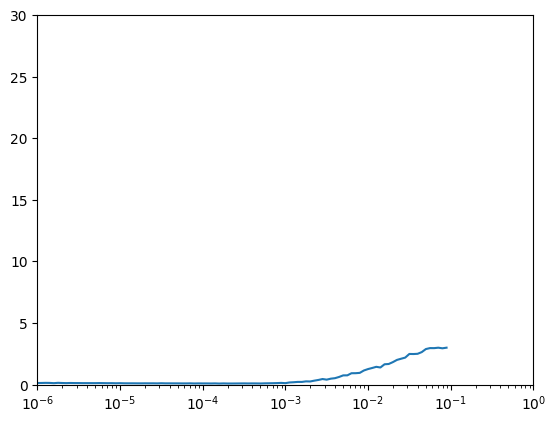

In [54]:
# Plot the loss for every LR
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-6, 1, 0, 30])

# Save Entire Model 

As SavedModel

In [59]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model\assets


INFO:tensorflow:Assets written to: saved_model/my_model\assets


In [ ]:
# my_model directory
ls saved_model

# Contains an assets folder, saved_model.pb, and variables folder.
ls saved_model/my_model

In [ ]:
new_model = tf.keras.models.load_model('saved_model/my_model')

# Check its architecture
new_model.summary()

In [ ]:
# Evaluate the restored model
loss, acc = new_model.evaluate(test_images, test_labels, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

print(new_model.predict(test_images).shape)

As HDF5 Format

In [ ]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('my_model.h5')

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('my_model.h5')

# Show the model architecture
new_model.summary()

In [ ]:
loss, acc = new_model.evaluate(test_images, test_labels, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))